In this notebook you can reproduce the simulation figures to test the PCA denoising algorithm in a 9 fiber phantom with uncorrelated noise. Here, results are plotted for two quantities reconstructed using the diffusional kurtosis imaging model (DKI).

Let's import the relevant modules for these simulations.

In [1]:
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt

from scipy.linalg import eigh
from scipy.ndimage.filters import gaussian_filter

import dipy.reconst.dki as dki
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.data import get_sphere, get_fnames
from dipy.core.gradients import gradient_table

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

The cells below contains the new parts of the code produced for this project, including:

<ins>1) Functions to assess the performance of denoising </ins>

In [2]:
def mp_distribution(x, var, y):
    """ Samples the Marchenko–Pastur probability distribution
    Parameters
    ----------
    x : array (N,)
        Values of random variable to sample the probability distribution
    var : float
        Variance of the random variable
    y : float
        Parameter associated to the matrix X that produces the distributions.
        This X is a M x N random matrix which columns entries are identical
        distributed random variables with mean 0 and given variance, y is given
        by N/M.
    """
    xpos = var * (1 + np.sqrt(y)) ** 2
    xneg = var * (1 - np.sqrt(y)) ** 2

    p = np.zeros(x.shape)
    xdis = np.logical_and(x<xpos, x>xneg)
    p[xdis] = np.sqrt((xpos-x[xdis]) * (x[xdis]-xneg)) / (2*np.pi*var*y*x[xdis])
    if np.sum(p) == 0:
        return p
    else:
        return p / np.sum(p)

    
def _pca_classifier(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    var = np.mean(L)
    c = L.size - 1
    r = L[c] - L[0] - 4 * np.sqrt((L.size) / nvoxels) * var
    while r > 0:
        var = np.mean(L[:c])
        c = c - 1
        sig_mp = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels)) 
        r =  sig_mp - var
    ncomps = c + 1
    return var, ncomps


def _gpca_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def _tpca_classifier(L, varest, tau_factor):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    tau = tau_factor ** 2 * varest
    ncomps = np.sum(L < tau)
    var = np.mean(L[:ncomps])

    return var, ncomps


def _pca_classifier_code(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    rang = np.zeros(L.shape)
    sig2 = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])
        c = c - 1
        rang[c] = L[c] - L[0] 
        #sig2[c] =  4 * np.sqrt((c + 1.0) / nvoxels) * var
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((L.size) / nvoxels))
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((c + 1.0) / nvoxels))
    return var, sig2


def _pca_classifier_code2(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    sig2_w = np.zeros(L.shape)
    sig2_m = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])  #RHS
        c = c - 1
        sig2_w[c] = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels))
        sig2_m[c] = var
    return sig2_m, sig2_w



def _pca_matrix(X, sig2=None, pca_method='eig', tau_factor=None):
    """ Helper function to perform PCA-denoising of a 2D matrix

    Parameters
    ----------
    X : 2D array (m, n)
        2D matrix to denoise

    Returns
    -------
    Xd : 2D array (m, n)
        Denoised 2D matrix

    Notes
    -----
    If sigma is None it used MPPCA
    If sigma and tau_factor is given, it used threshold approach
    If sigma is given but not tau_factor, it uses the TPCA approach
    
    """
    n = X.shape[1]
    m = X.shape[0]
    X0 = X.copy()

    if pca_method.lower() == 'svd':
        is_svd = True
    else:
        is_svd = False
    
    M = np.mean(X0, axis=0)
    X0 = X0 - M

    if is_svd:
        # PCA using an SVD
        U, S, Vt = svd(X0, *svd_args)[:3]
        # Items in S are the eigenvalues, but in ascending order
        # We invert the order (=> descending), square and normalize
        # \lambda_i = s_i^2 / n
        d = S[::-1] ** 2 / X.shape[0]
        # Rows of Vt are eigenvectors, but also in ascending
        # eigenvalue order:
        W = Vt[::-1].T

    else:
        # PCA using an Eigenvalue decomposition
        C = np.transpose(X0).dot(X0)
        C = C / X.shape[0]
        [d, W] = eigh(C, turbo=True)

    if sig2 is None:
        # Random matrix theory
        this_var, ncomps = _pca_classifier(d, m)
        
    else:
        # Predefined variance
        this_var = sig2
        if tau_factor is None:
            this_var, ncomps = _gpca_classifier(d, this_var)
        else:
            # tau_factor = 1 + np.sqrt(n / m)
            tau = tau_factor ** 2 * this_var
            # Update ncomps according to tau_factor
            ncomps = np.sum(d < tau)

    W[:, :ncomps] = 0

    # This is equations 1 and 2 in Manjon 2013:
    Xd = X0.dot(W).dot(W.T) + M

    return Xd, ncomps

<ins> 2) Functions to produce data phantom </ins>

In [3]:
def fib3_phantom_9comps(gtab, snr=None, noise_type='G', N=30):
    """Phantom with three orthogonal fibers"""

    xa = int(1/3 * N)
    
    # sampled 9 directions
    n_pts = 9
    #theta = np.pi * np.random.rand(n_pts)
    #phi = 2 * np.pi * np.random.rand(n_pts)
    #hsph_initial = HemiSphere(theta=theta, phi=phi)
    #hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    #directions = hsph_updated.vertices
    
    directions = np.array([[0.9991, -0.0357, -0.0242],
                           [-0.0034, 0.5586, -0.8294],
                           [0.0427, 0.8323, 0.5527],
                           [0.0278, 0.9809, -0.1923],
                           [0.7252, 0.6711, -0.1538],
                           [0.7303, 0.1161, 0.6732],
                           [-0.0328, -0.1969, -0.9799],
                           [0.6842, -0.1635, -0.7107],
                           [0.6860, -0.7182, 0.1171]])
    
    # define voxel index
    slice_ind = np.zeros((N, N))
    slice_ind[0:xa, 0:xa] = 0
    slice_ind[0:xa, xa:2*xa] = 1
    slice_ind[0:xa, 2*xa:3*xa] = 2
    slice_ind[xa:2*xa, 0:xa] = 3
    slice_ind[xa:2*xa, xa:2*xa] = 4
    slice_ind[xa:2*xa, 2*xa:3*xa] = 5
    slice_ind[2*xa:3*xa, 0:xa] = 6
    slice_ind[2*xa:3*xa, xa:2*xa] = 7
    slice_ind[2*xa:3*xa, 2*xa:3*xa] = 8

    # Define tisse diffusion parameters
    # Restricted diffusion
    ADr = 1.8e-3
    RDr = 0.0
    # Hindered diffusion
    ADh = 1.5e-3
    RDh = 0.5e-3

    # Fraction between Restricted and Hindered diffusion (in index order)
    f = np.array([0.1, 0.2, 0.3,
                  0.4, 0.5, 0.6,
                  0.7, 0.8, 0.9])

    # produce signals according to multi-tensor code
    mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh]])
    axyz = directions
    DWI = np.zeros((N, N, gtab.bvals.size))
    for vi in range(9):
        fractions = [f[vi]*100, (1-f[vi])*100]
        sig, direction = multi_tensor(gtab, mevals, angles=[axyz[vi], axyz[vi]],
                                      fractions=fractions, snr=None)
        DWI[slice_ind == vi, :] = sig
        #print([axyz[vi], axyz[vi]])

    if snr is None:
        return DWI
    else:
        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = 1.0 /snr
        n1 = np.random.normal(0, sigma, size=DWI.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=DWI.shape)

        return noise_adder[noise_type](DWI, n1, n2)

<ins> 3) Functions to corrupt phantom with spatially uncorrelated noise </ins>

In [4]:
def add_noise_phantom(Phantom, snr=None, noise_type='gaussian'):
    if snr is None:
        return Phantom
    else:
        S1 = 1

        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = S1 * 1.0 /snr
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=Phantom.shape)

        return noise_adder[noise_type](Phantom, n1, n2)   

<ins> 4) Functions to add spatial correlations </ins>

In [5]:
def smooth(data, gauss_std):
    data_smooth = np.zeros(data.shape)
    for v in range(data.shape[-1]):
        data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)
    return data_smooth

def zero_fill(dwi, nz):
    nvol = dwi.shape
    nvo = nvol[2]
    for jj in range(nvo):
        c = np.fft.fft2(dwi[:, :, jj])
        c = np.fft.fftshift(c)
        # if you want to add zero filling in all image boundaries
        # you can uncomment lines of code below
        #c[:, :nz] = 0
        c[(-nz-1):, :] = 0 
        # c[:nz, :] = 0
        #c[:, (-nz-1):] = 0 
        dwi[:, :, jj] = abs(np.fft.ifft2(c))
    return dwi

# Simulation settings

In the cell below you can change the settings of different parameters of the simulations. Example you can change: 1) the simulations SNR of the initial raw data; 2) method two generated spatiaaly correlated noise (if corrupt == 1 spatially correlated noise is generated by smoothing the noisy and ground truth data, if corrupt == 2 spatially correlated noise is generated by zero-filling the noisy and ground truth data)

In [6]:
snr = 30
N = 12  # dimension of the phantom will be NxN

# If gaussian==false, Rician noise is used
gaussian = True

# corrupt 1 noise is spatial correlated by adding smoothing to noise corrupted phantoms
# corrupt 2 noise is spatial correlated by adding zero filling
corrupt = 2
zf = int(N/4)  # number of voxels for zero-filling corruption 
gauss_std = 0.6 # std of Gaussian kernel for gaussian noise corruption

Initialize seed so that random instances are reproducible when reruning the notebook again.
If you are interested in assessing the generality of the results for other noise instances, you can just ignore this command line.

In [7]:
np.random.seed(10)

# Simulate acquisition parameters

Signals are generated for 110 different sets of single diffusion encoding (SDE), comprising 20 b-value=0 experiments and 30 gradient directions for b-values 1000, 2000, and 3000 s/mm2

In [8]:
# Sample the spherical cordinates of 30 evenly distributed
# diffusion-weighted directions
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
V = hsph_updated.vertices

# Reconstruct acquisition parameters for 20 b0s and 45 directions for b=1000 and 2000
bvals = np.hstack((np.zeros(20), 1000 * np.ones(n_pts), 2000 * np.ones(n_pts), 3000 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((20, 3)), V, V, V))

# Generate a object containing the information of b-values and gradient directions
# (using the same format used in Dipy)
gtab = gradient_table(bvals, bvecs)

### Define DKI model

In [9]:
dkim = dki.DiffusionKurtosisModel(gtab)

### Ground truth Phantom

Let first generate ground truth phantoms

In [10]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

Let's fit DKI

In [11]:
dkifu = dkim.fit(DWI)
dkifc = dkim.fit(DWIc)

Below, I am showing the ground truth phantom MK and FA for spatially uncorrelated noise 

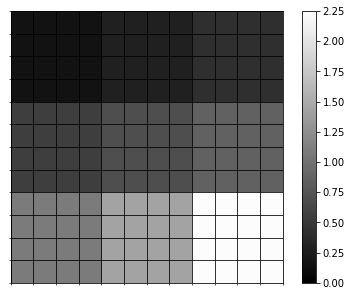

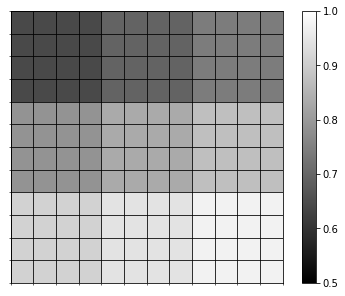

In [12]:
FA = dkifu.fa
MK = dkifu.mk()
FAgt_unc = FA
MKgt_unc = MK

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

Below, I am showing the ground truth phantom for spatially correlated noise 

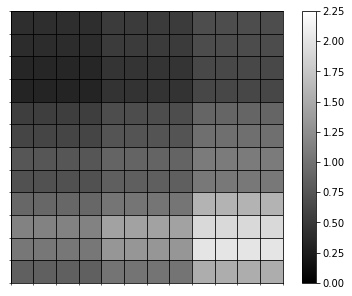

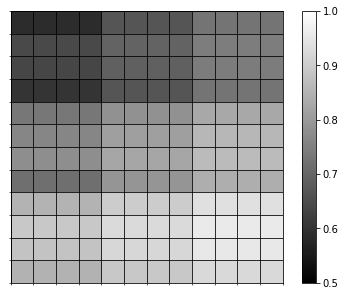

In [13]:
FA = dkifc.fa
MK = dkifc.mk()
FAgt_cor = FA
MKgt_cor = MK

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

# Add noise

In [14]:
sig2 = (1/snr) ** 2  

if gaussian:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
else:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')

if corrupt == 1:
    DWInc = smooth(DWIn, gauss_std)
if corrupt == 2:
    DWInc = zero_fill(DWIn.copy(), zf)

In [15]:
dkifu = dkim.fit(DWIn)
dkifc = dkim.fit(DWInc)

Let's plot the MK and FA reconstruction for noise corrupted data (<ins>Spatially uncorrelated noise</ins>)

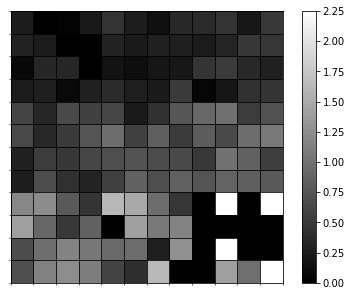

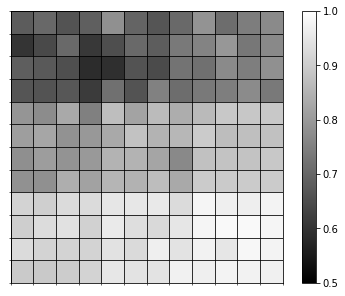

In [16]:
FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

Let's plot the MK and FA reconstruction for noise corrupted data (<ins>Spatially correlated noise</ins>)

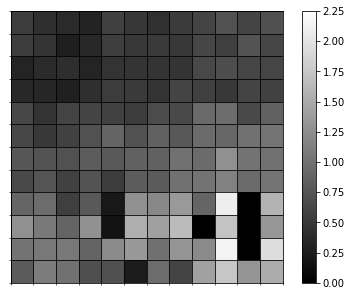

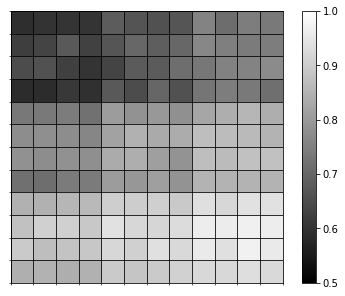

In [17]:
FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

# MPPCA Denoising

In [18]:
# Let's convert phantoms to a 2D matrix
n = DWIn.shape[-1]
m = DWIn.shape[0]*DWIn.shape[1]
y = n*1.0/m
X = DWIn.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
Xc = DWInc.reshape(m, n)
Mc = np.mean(Xc, axis=0)
Xc = Xc - Mc

In [19]:
# MP-PCA denoising
Xd, ncomps = _pca_matrix(X)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

Xdc, ncomps = _pca_matrix(Xc)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102
2


In [20]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

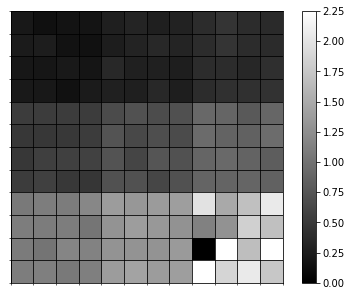

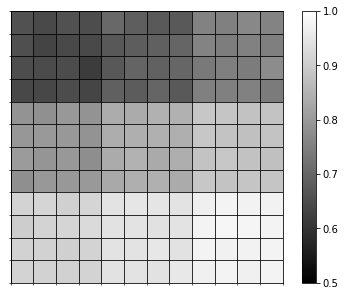

In [21]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

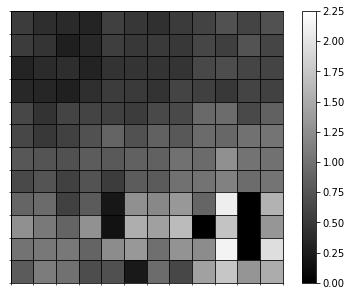

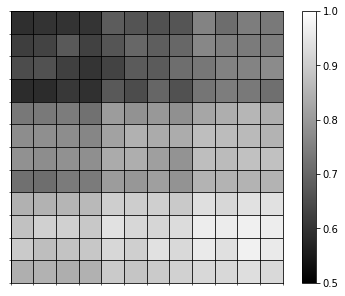

In [22]:
# Noise correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

MP-PCA successfully suppresses noise when it is spatially uncorrelated but its performance is limited on spatially correlated noise.

# GPCA Denoising

In [23]:
# General PCA denoising
varp1 = np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))
varp2 = np.mean(np.var(DWInc[..., gtab.b0s_mask], axis=-1, ddof=1))

Xd, ncomps = _pca_matrix(X, sig2=varp1)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

Xdc, ncomps = _pca_matrix(Xc, sig2=varp2)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102
102


In [24]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

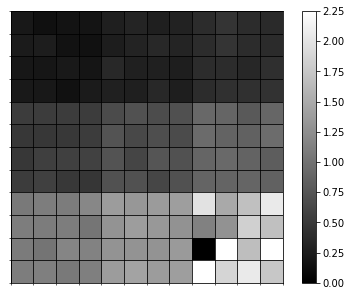

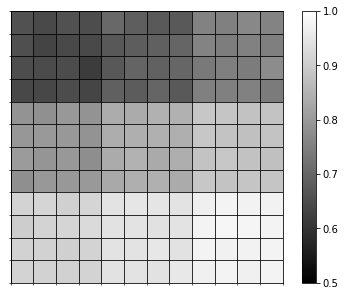

In [25]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

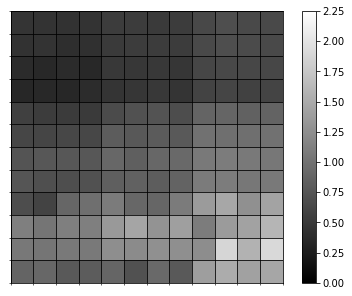

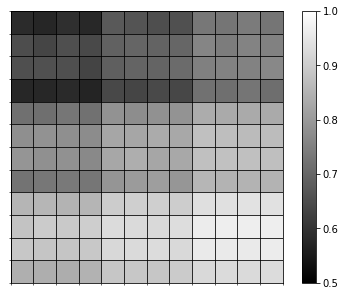

In [26]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

GPCA has an optimal performance for both spatially uncorrelated and correlated noise. For both cases, it correclty detected the 102 ground truth noise components of the phantoms.

# TPCA Denoising

In [27]:
Xd, ncomps = _pca_matrix(X, sig2=varp1, tau_factor=1+np.sqrt(n / m))
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

Xdc, ncomps = _pca_matrix(Xc, sig2=varp2, tau_factor=1+np.sqrt(n / m))
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102
100


In [28]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

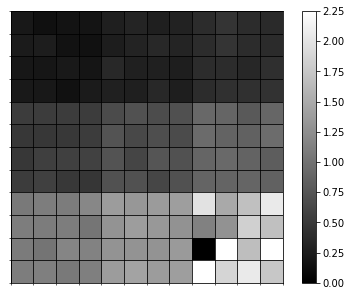

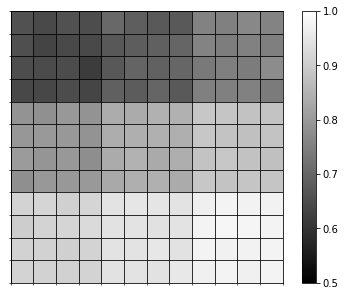

In [29]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

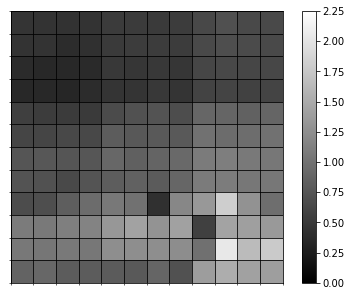

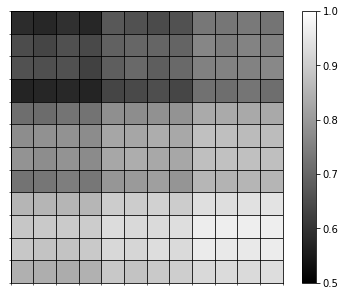

In [30]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

TPCA denoising also provides robust denoising for both spatially uncorrelated and correlated phantoms. However, it perserved 2 more signal components than expected.

# Quantification of SNR gain in kurtosis metrics

In [31]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

In [32]:
dkifc = dkim.fit(DWIc)

In [33]:
FAgt = dkifc.fa
MDgt = dkifc.md
ADgt = dkifc.ad
RDgt = dkifc.rd
MKgt = dkifc.mk()
AKgt = dkifc.ak()
RKgt = dkifc.rk()

In [34]:
FAgt = FAgt.reshape(m)
MDgt = MDgt.reshape(m)
ADgt = ADgt.reshape(m)
RDgt = RDgt.reshape(m)
MKgt = MKgt.reshape(m)
AKgt = AKgt.reshape(m)
RKgt = RKgt.reshape(m)

In [35]:
# spatially correlated noise

nrep = 100

FAraw_e = np.array([])
MDraw_e = np.array([])
ADraw_e = np.array([])
RDraw_e = np.array([])
MKraw_e = np.array([])
AKraw_e = np.array([])
RKraw_e = np.array([])

FAmpca_e = np.array([])
MDmpca_e = np.array([])
ADmpca_e = np.array([])
RDmpca_e = np.array([])
MKmpca_e = np.array([])
AKmpca_e = np.array([])
RKmpca_e = np.array([])

FAgpca_e = np.array([])
MDgpca_e = np.array([])
ADgpca_e = np.array([])
RDgpca_e = np.array([])
MKgpca_e = np.array([])
AKgpca_e = np.array([])
RKgpca_e = np.array([])

FAtpca_e = np.array([])
MDtpca_e = np.array([])
ADtpca_e = np.array([])
RDtpca_e = np.array([])
MKtpca_e = np.array([])
AKtpca_e = np.array([])
RKtpca_e = np.array([])

over_fac = 1

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    if corrupt == 1:
        DWIn = smooth(DWIn.copy(), gauss_std)
    else:
        DWIn = zero_fill(DWIn.copy(), zf)
    var_all = (over_fac**2) * np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    
    # Raw
    dki_raw = dkim.fit(X)
    FAraw_e = np.append(FAraw_e, dki_raw.fa - FAgt)
    MDraw_e = np.append(MDraw_e, dki_raw.md - MDgt)
    ADraw_e = np.append(ADraw_e, dki_raw.ad - ADgt)
    RDraw_e = np.append(RDraw_e, dki_raw.rd - RDgt)
    MKraw_e = np.append(MKraw_e, dki_raw.mk() - MKgt)
    AKraw_e = np.append(AKraw_e, dki_raw.ak() - AKgt)
    RKraw_e = np.append(RKraw_e, dki_raw.rk() - RKgt)
    
    X = X - M
    
    # MPPCA
    Xmpca, ncomps = _pca_matrix(X)
    Xmpca = Xmpca + M
    dki_mpca = dkim.fit(Xmpca)
    FAmpca_e = np.append(FAmpca_e, dki_mpca.fa - FAgt)
    MDmpca_e = np.append(MDmpca_e, dki_mpca.md - MDgt)
    ADmpca_e = np.append(ADmpca_e, dki_mpca.ad - ADgt)
    RDmpca_e = np.append(RDmpca_e, dki_mpca.rd - RDgt)
    MKmpca_e = np.append(MKmpca_e, dki_mpca.mk() - MKgt)
    AKmpca_e = np.append(AKmpca_e, dki_mpca.ak() - AKgt)
    RKmpca_e = np.append(RKmpca_e, dki_mpca.rk() - RKgt)
    
    # GPCA
    Xgpca, ncomps = _pca_matrix(X, sig2=var_all)
    Xgpca = Xgpca + M
    dki_gpca = dkim.fit(Xgpca)
    FAgpca_e = np.append(FAgpca_e, dki_gpca.fa - FAgt)
    MDgpca_e = np.append(MDgpca_e, dki_gpca.md - MDgt)
    ADgpca_e = np.append(ADgpca_e, dki_gpca.ad - ADgt)
    RDgpca_e = np.append(RDgpca_e, dki_gpca.rd - RDgt)
    MKgpca_e = np.append(MKgpca_e, dki_gpca.mk() - MKgt)
    AKgpca_e = np.append(AKgpca_e, dki_gpca.ak() - AKgt)
    RKgpca_e = np.append(RKgpca_e, dki_gpca.rk() - RKgt)
    
    # TPCA
    Xtpca, ncomps = _pca_matrix(X, sig2=var_all, tau_factor=1+np.sqrt(n / m))
    Xtpca = Xtpca + M
    dki_tpca = dkim.fit(Xtpca)
    FAtpca_e = np.append(FAtpca_e, dki_tpca.fa - FAgt)
    MDtpca_e = np.append(MDtpca_e, dki_tpca.md - MDgt)
    ADtpca_e = np.append(ADtpca_e, dki_tpca.ad - ADgt)
    RDtpca_e = np.append(RDtpca_e, dki_tpca.rd - RDgt)
    MKtpca_e = np.append(MKtpca_e, dki_tpca.mk() - MKgt)
    AKtpca_e = np.append(AKtpca_e, dki_tpca.ak() - AKgt)
    RKtpca_e = np.append(RKtpca_e, dki_tpca.rk() - RKgt)
    
    print(rep)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [36]:
FAraw_e.shape

(14400,)

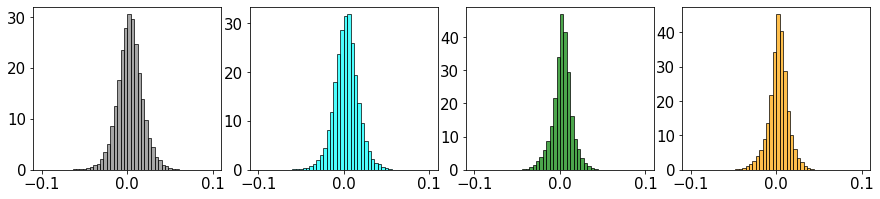

In [37]:
plt.rcParams.update({'font.size': 15})

fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.15)

counts, ed = np.histogram(FAraw_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAmpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAgpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAtpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')


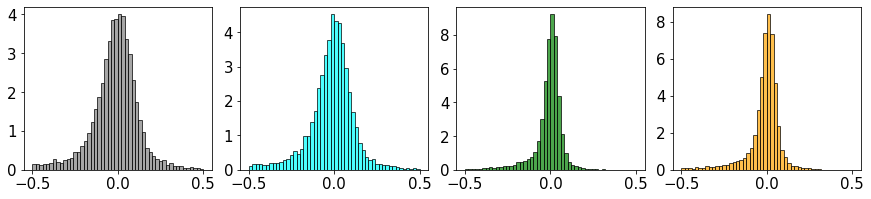

In [38]:
plt.rcParams.update({'font.size': 15})

fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.15)

counts, ed = np.histogram(MKraw_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKmpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKgpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKtpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')


In [39]:
plt.rcParams.update({'font.size': 10})

In [40]:
RMSEfa_raw = np.sqrt(np.mean(FAraw_e ** 2))
RMSEmd_raw = np.sqrt(np.mean(MDraw_e ** 2)) * 1000
RMSErd_raw = np.sqrt(np.mean(RDraw_e ** 2)) * 1000
RMSEad_raw = np.sqrt(np.mean(ADraw_e ** 2)) * 1000
RMSEmk_raw = np.sqrt(np.mean(MKraw_e ** 2))
RMSErk_raw = np.sqrt(np.mean(RKraw_e ** 2))
RMSEak_raw = np.sqrt(np.mean(AKraw_e ** 2))

RMSEfa_mpca = np.sqrt(np.mean(FAmpca_e ** 2))
RMSEmd_mpca = np.sqrt(np.mean(MDmpca_e ** 2)) * 1000
RMSErd_mpca = np.sqrt(np.mean(RDmpca_e ** 2)) * 1000
RMSEad_mpca = np.sqrt(np.mean(ADmpca_e ** 2)) * 1000
RMSEmk_mpca = np.sqrt(np.mean(MKmpca_e ** 2))
RMSErk_mpca = np.sqrt(np.mean(RKmpca_e ** 2))
RMSEak_mpca = np.sqrt(np.mean(AKmpca_e ** 2))

RMSEfa_gpca = np.sqrt(np.mean(FAgpca_e ** 2))
RMSEmd_gpca = np.sqrt(np.mean(MDgpca_e ** 2)) * 1000
RMSErd_gpca = np.sqrt(np.mean(RDgpca_e ** 2)) * 1000
RMSEad_gpca = np.sqrt(np.mean(ADgpca_e ** 2)) * 1000
RMSEmk_gpca = np.sqrt(np.mean(MKgpca_e ** 2))
RMSErk_gpca = np.sqrt(np.mean(RKgpca_e ** 2))
RMSEak_gpca = np.sqrt(np.mean(AKgpca_e ** 2))
    
RMSEfa_tpca = np.sqrt(np.mean(FAtpca_e ** 2))
RMSEmd_tpca = np.sqrt(np.mean(MDtpca_e ** 2)) * 1000
RMSErd_tpca = np.sqrt(np.mean(RDtpca_e ** 2)) * 1000
RMSEad_tpca = np.sqrt(np.mean(ADtpca_e ** 2)) * 1000
RMSEmk_tpca = np.sqrt(np.mean(MKtpca_e ** 2))
RMSErk_tpca = np.sqrt(np.mean(RKtpca_e ** 2))
RMSEak_tpca = np.sqrt(np.mean(AKtpca_e ** 2))

In [41]:
print('Raw')
print(RMSEfa_raw)
print(RMSEmd_raw)
print(RMSErd_raw)
print(RMSEad_raw)
print(RMSEmk_raw)
print(RMSErk_raw)
print(RMSEad_raw)
print(' ')
print('MPPCA')
print(RMSEfa_mpca)
print(RMSEmd_mpca)
print(RMSErd_mpca)
print(RMSEad_mpca)
print(RMSEmk_mpca)
print(RMSErk_mpca)
print(RMSEad_mpca)
print(' ')
print('GPCA')
print(RMSEfa_gpca)
print(RMSEmd_gpca)
print(RMSErd_gpca)
print(RMSEad_gpca)
print(RMSEmk_gpca)
print(RMSErk_gpca)
print(RMSEad_gpca)
print(' ')
print('TPCA')
print(RMSEfa_tpca)
print(RMSEmd_tpca)
print(RMSErd_tpca)
print(RMSEad_tpca)
print(RMSEmk_tpca)
print(RMSErk_tpca)
print(RMSEad_tpca)

Raw
0.015103478243323119
0.01732048104899873
0.014850615476639606
0.05223844917184254
0.27718423249765833
1.3508827183978278
0.05223844917184254
 
MPPCA
0.014439402505879079
0.016242183704776054
0.014044470891227356
0.049793094087146834
0.25445874248270606
1.2734538736958585
0.049793094087146834
 
GPCA
0.011531464961344131
0.00992877839764536
0.009248548767668658
0.03794224130793706
0.12017555712446738
0.6525521451591517
0.03794224130793706
 
TPCA
0.011722537731587712
0.010437885625648057
0.009601566480852964
0.03880424083031288
0.13168196797042528
0.6967260753296461
0.03880424083031288


# Results for overestimates variance estimates

In [42]:
over_fac = 1.6

In [43]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

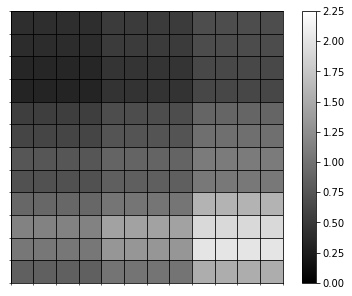

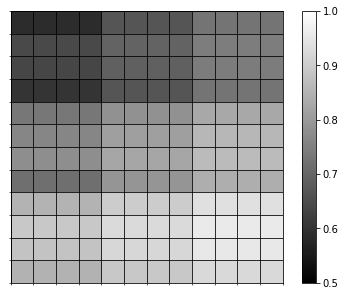

In [44]:
dkifc = dkim.fit(DWIc)

FA = dkifc.fa
MK = dkifc.mk()
FAgt_cor = FA
MKgt_cor = MK

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [45]:
sig2 = (1/snr) ** 2  

if gaussian:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
else:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')

if corrupt == 1:
    DWInc = smooth(DWIn, gauss_std)
if corrupt == 2:
    DWInc = zero_fill(DWIn.copy(), zf)

In [46]:
# General PCA denoising
varp2 = (over_fac**2) * np.mean(np.var(DWInc[..., gtab.b0s_mask], axis=-1, ddof=1))

Xdc, ncomps = _pca_matrix(Xc, sig2=varp2)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

103


In [47]:
dkifc = dkim.fit(DWIdc)

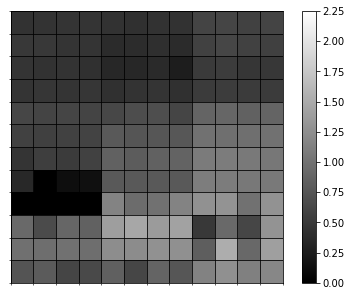

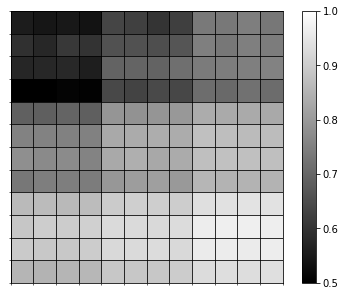

In [48]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

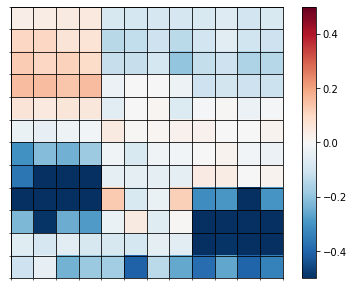

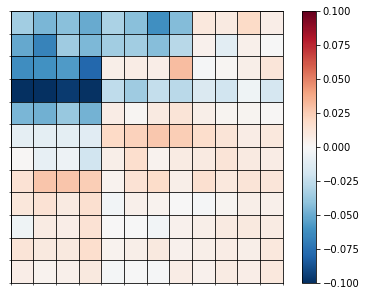

In [49]:
# Correlated

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :]-MKgt_cor[:, :], cmap="RdBu_r", vmin=-.5, vmax=.5)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :]-FAgt_cor[:, :], cmap="RdBu_r", vmin=-0.1, vmax=0.1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [50]:
# TPCA denoising
Xdc, ncomps = _pca_matrix(Xc, sig2=varp2, tau_factor=1+np.sqrt(n / m))
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102


In [51]:
dkifc = dkim.fit(DWIdc)

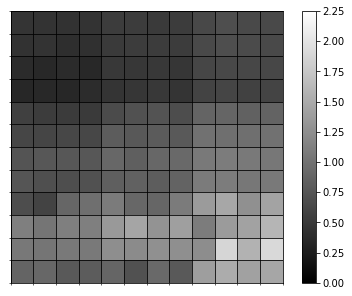

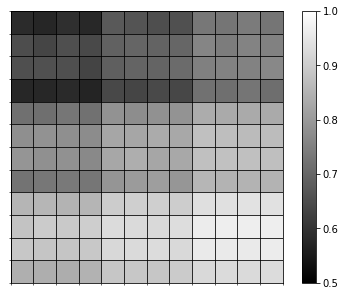

In [52]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=2.25)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0.5, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

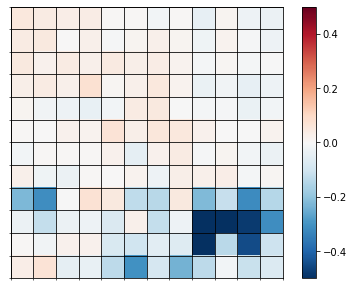

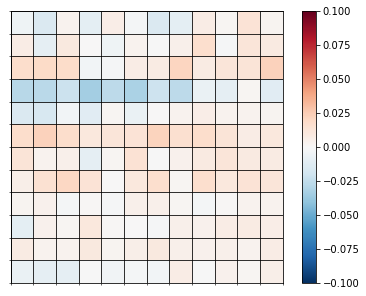

In [53]:
# Correlated

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :]-MKgt_cor[:, :], cmap="RdBu_r", vmin=-.5, vmax=.5)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :]-FAgt_cor[:, :], cmap="RdBu_r", vmin=-0.1, vmax=0.1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [54]:
# spatially correlated noise

nrep = 100

FAraw_e = np.array([])
MDraw_e = np.array([])
ADraw_e = np.array([])
RDraw_e = np.array([])
MKraw_e = np.array([])
AKraw_e = np.array([])
RKraw_e = np.array([])

FAmpca_e = np.array([])
MDmpca_e = np.array([])
ADmpca_e = np.array([])
RDmpca_e = np.array([])
MKmpca_e = np.array([])
AKmpca_e = np.array([])
RKmpca_e = np.array([])

FAgpca_e = np.array([])
MDgpca_e = np.array([])
ADgpca_e = np.array([])
RDgpca_e = np.array([])
MKgpca_e = np.array([])
AKgpca_e = np.array([])
RKgpca_e = np.array([])

FAtpca_e = np.array([])
MDtpca_e = np.array([])
ADtpca_e = np.array([])
RDtpca_e = np.array([])
MKtpca_e = np.array([])
AKtpca_e = np.array([])
RKtpca_e = np.array([])

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    if corrupt == 1:
        DWIn = smooth(DWIn.copy(), gauss_std)
    else:
        DWIn = zero_fill(DWIn.copy(), zf)
    var_all = (over_fac**2) * np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    
    # Raw
    dki_raw = dkim.fit(X)
    FAraw_e = np.append(FAraw_e, dki_raw.fa - FAgt)
    MDraw_e = np.append(MDraw_e, dki_raw.md - MDgt)
    ADraw_e = np.append(ADraw_e, dki_raw.ad - ADgt)
    RDraw_e = np.append(RDraw_e, dki_raw.rd - RDgt)
    MKraw_e = np.append(MKraw_e, dki_raw.mk() - MKgt)
    AKraw_e = np.append(AKraw_e, dki_raw.ak() - AKgt)
    RKraw_e = np.append(RKraw_e, dki_raw.rk() - RKgt)
    
    X = X - M
    
    # MPPCA
    Xmpca, ncomps = _pca_matrix(X)
    Xmpca = Xmpca + M
    dki_mpca = dkim.fit(Xmpca)
    FAmpca_e = np.append(FAmpca_e, dki_mpca.fa - FAgt)
    MDmpca_e = np.append(MDmpca_e, dki_mpca.md - MDgt)
    ADmpca_e = np.append(ADmpca_e, dki_mpca.ad - ADgt)
    RDmpca_e = np.append(RDmpca_e, dki_mpca.rd - RDgt)
    MKmpca_e = np.append(MKmpca_e, dki_mpca.mk() - MKgt)
    AKmpca_e = np.append(AKmpca_e, dki_mpca.ak() - AKgt)
    RKmpca_e = np.append(RKmpca_e, dki_mpca.rk() - RKgt)
    
    # GPCA
    Xgpca, ncomps = _pca_matrix(X, sig2=var_all)
    Xgpca = Xgpca + M
    dki_gpca = dkim.fit(Xgpca)
    FAgpca_e = np.append(FAgpca_e, dki_gpca.fa - FAgt)
    MDgpca_e = np.append(MDgpca_e, dki_gpca.md - MDgt)
    ADgpca_e = np.append(ADgpca_e, dki_gpca.ad - ADgt)
    RDgpca_e = np.append(RDgpca_e, dki_gpca.rd - RDgt)
    MKgpca_e = np.append(MKgpca_e, dki_gpca.mk() - MKgt)
    AKgpca_e = np.append(AKgpca_e, dki_gpca.ak() - AKgt)
    RKgpca_e = np.append(RKgpca_e, dki_gpca.rk() - RKgt)
    
    # TPCA
    Xtpca, ncomps = _pca_matrix(X, sig2=var_all, tau_factor=1+np.sqrt(n / m))
    Xtpca = Xtpca + M
    dki_tpca = dkim.fit(Xtpca)
    FAtpca_e = np.append(FAtpca_e, dki_tpca.fa - FAgt)
    MDtpca_e = np.append(MDtpca_e, dki_tpca.md - MDgt)
    ADtpca_e = np.append(ADtpca_e, dki_tpca.ad - ADgt)
    RDtpca_e = np.append(RDtpca_e, dki_tpca.rd - RDgt)
    MKtpca_e = np.append(MKtpca_e, dki_tpca.mk() - MKgt)
    AKtpca_e = np.append(AKtpca_e, dki_tpca.ak() - AKgt)
    RKtpca_e = np.append(RKtpca_e, dki_tpca.rk() - RKgt)
    
    print(rep)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


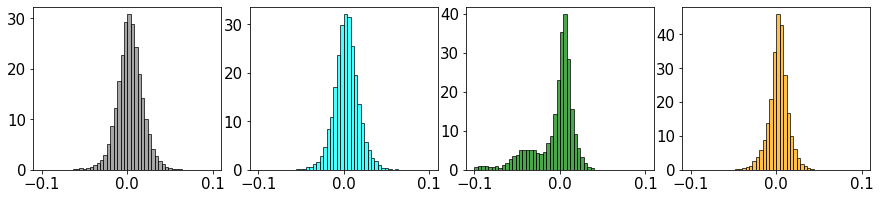

In [55]:
plt.rcParams.update({'font.size': 15})

fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.15)

counts, ed = np.histogram(FAraw_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAmpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAgpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAtpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = (0.2)/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

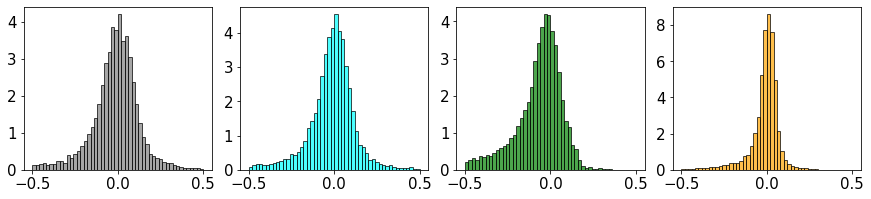

In [56]:
plt.rcParams.update({'font.size': 15})

fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.15)

counts, ed = np.histogram(MKraw_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKmpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKgpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKtpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

In [57]:
RMSEfa_raw = np.sqrt(np.mean(FAraw_e ** 2))
RMSEmd_raw = np.sqrt(np.mean(MDraw_e ** 2)) * 1000
RMSErd_raw = np.sqrt(np.mean(RDraw_e ** 2)) * 1000
RMSEad_raw = np.sqrt(np.mean(ADraw_e ** 2)) * 1000
RMSEmk_raw = np.sqrt(np.mean(MKraw_e ** 2))
RMSErk_raw = np.sqrt(np.mean(RKraw_e ** 2))
RMSEak_raw = np.sqrt(np.mean(AKraw_e ** 2))

RMSEfa_mpca = np.sqrt(np.mean(FAmpca_e ** 2))
RMSEmd_mpca = np.sqrt(np.mean(MDmpca_e ** 2)) * 1000
RMSErd_mpca = np.sqrt(np.mean(RDmpca_e ** 2)) * 1000
RMSEad_mpca = np.sqrt(np.mean(ADmpca_e ** 2)) * 1000
RMSEmk_mpca = np.sqrt(np.mean(MKmpca_e ** 2))
RMSErk_mpca = np.sqrt(np.mean(RKmpca_e ** 2))
RMSEak_mpca = np.sqrt(np.mean(AKmpca_e ** 2))

RMSEfa_gpca = np.sqrt(np.mean(FAgpca_e ** 2))
RMSEmd_gpca = np.sqrt(np.mean(MDgpca_e ** 2)) * 1000
RMSErd_gpca = np.sqrt(np.mean(RDgpca_e ** 2)) * 1000
RMSEad_gpca = np.sqrt(np.mean(ADgpca_e ** 2)) * 1000
RMSEmk_gpca = np.sqrt(np.mean(MKgpca_e ** 2))
RMSErk_gpca = np.sqrt(np.mean(RKgpca_e ** 2))
RMSEak_gpca = np.sqrt(np.mean(AKgpca_e ** 2))
    
RMSEfa_tpca = np.sqrt(np.mean(FAtpca_e ** 2))
RMSEmd_tpca = np.sqrt(np.mean(MDtpca_e ** 2)) * 1000
RMSErd_tpca = np.sqrt(np.mean(RDtpca_e ** 2)) * 1000
RMSEad_tpca = np.sqrt(np.mean(ADtpca_e ** 2)) * 1000
RMSEmk_tpca = np.sqrt(np.mean(MKtpca_e ** 2))
RMSErk_tpca = np.sqrt(np.mean(RKtpca_e ** 2))
RMSEak_tpca = np.sqrt(np.mean(AKtpca_e ** 2))

In [58]:
print('Raw')
print(RMSEfa_raw)
print(RMSEmd_raw)
print(RMSErd_raw)
print(RMSEad_raw)
print(RMSEmk_raw)
print(RMSErk_raw)
print(RMSEad_raw)
print(' ')
print('MPPCA')
print(RMSEfa_mpca)
print(RMSEmd_mpca)
print(RMSErd_mpca)
print(RMSEad_mpca)
print(RMSEmk_mpca)
print(RMSErk_mpca)
print(RMSEad_mpca)
print(' ')
print('GPCA')
print(RMSEfa_gpca)
print(RMSEmd_gpca)
print(RMSErd_gpca)
print(RMSEad_gpca)
print(RMSEmk_gpca)
print(RMSErk_gpca)
print(RMSEad_gpca)
print(' ')
print('TPCA')
print(RMSEfa_tpca)
print(RMSEmd_tpca)
print(RMSErd_tpca)
print(RMSEad_tpca)
print(RMSEmk_tpca)
print(RMSErk_tpca)
print(RMSEad_tpca)

Raw
0.015202157619062573
0.017208279595716133
0.014886687414942859
0.05206054732969379
0.2832650281585426
1.3390956907387426
0.05206054732969379
 
MPPCA
0.014497970270317278
0.016136286690793197
0.013978955436652847
0.0496297487269125
0.2659512073175451
1.2635779436314267
0.0496297487269125
 
GPCA
0.02621309272370653
0.01274792963406184
0.019524152251651345
0.06038199069433822
0.2892304781710175
1.3675241083258352
0.06038199069433822
 
TPCA
0.01156274534552246
0.01001263346227007
0.009259306354042112
0.03820063021806656
0.1161085528704393
0.6035408421636391
0.03820063021806656
